## Anomaly Detection Filter explained & example

In [1]:
# Download any missing packages 
#!pip install antares_client

In [2]:
import warnings
warnings.filterwarnings('ignore')  #suppress annoying deprecation warnings

import antares_client
from antares_client.search import get_by_id

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

plt.rc('font', size=15)
%config InlineBackend.figure_format = 'retina'  #for MacOS, make plots crisp

#### Running this notebook

This notebook has been replicated to run on Google Colab here: https://colab.research.google.com/drive/12Vf8tL_HqejskVDb3uIlgzADLDOADUhm?usp=sharing 

You will have to:

1. sign into your Google account
2. acknowledge that the notebook was not written by Google and click "Run Anyway"
3. select Runtime --> Run all


Or, if you already have a datalab account at https://datalab.noirlab.edu, you can run this notebook under quickstart --> launch a jupyter notebook 
<img src="datalab_jupyter_screenshot.png">

### Filter background

We can search for loci by their associated tags, where a tag is produced by a single Filter. We are interested in the newly implemented (April 5, 2021) anomaly detection filter, written by Patrick Aleo and Konstantin Malanchev on behalf of the ANTARES team. 

The anomaly detection filter aims to tag transient events like supernovae, cataclysmic variables, and weird events/objects in the night sky. It is an isolation forest-based algorithm trained on 1,000,000 ANTARES alerts on 106 total light curve features (i.e. periodogram, stetson K, linear trend, etc.-- for full list see https://antares.noirlab.edu/properties), 53 for both R and g bands. 

Out of 1 million loci drawn from all over the sky, the overwhelming majority will be rather common non-variable stars and objects. But a small subsect of loci will be highly variable and short-lived transient events. In the streaming alerts-era, we want to catch, prioritize quick followup of, and study exotic objects/events in the midst of their interesting behavior instead of weeks or months later, which is often times too late. Thus, a Filter which looks for anomalous objects every night as new alerts come in is incredibly useful, particularly for short-lived, time sensitive events like supernovae.

Each loci which has the "lc_feature_extractor" tag (currently 1.8 million) and all 106 features calculated can pass through to be assigned an anomaly score by the anomaly detection filter. Here is the performance of the Filter on a testing set of ~500,000 alerts: 

<img src="anom_score_distribution.png" width="500" height="600">

Currently a loci with an anomaly score > 0.53, does not live in the galactic plane (abs(b) > 10) and is not extremely red and does not have its strongest period between 100 and 1000 days (i.e. to weed out Mira stars) are tagged an "anomaly/outlier".

### Searching for anomalous/outlier loci

To find all the anomalous/outlier loci with the "iso_forest_anomaly_detection" tag, we can use the ANTARES elastic search query:

In [3]:
%%time

query = {
    "query": {
        "term": {
            "tags": "iso_forest_anomaly_detection"
        }
    }
}
loci = antares_client.search.search(query)
locus_ids = [l.locus_id for l in loci]

CPU times: user 50.3 ms, sys: 7.65 ms, total: 58 ms
Wall time: 274 ms


All the ANTARES loci which successfully passes the conditions for the anomaly detection filter are collected here in a list. Because this filter is new, the amount of anomalous loci are small (24 objects):

In [4]:
locus_ids

['ANT2021jbiyi',
 'ANT2021iyfc6',
 'ANT2021icbwo',
 'ANT2020h3tgu',
 'ANT2021h7pyw',
 'ANT2021i5u3k',
 'ANT2021imi3y',
 'ANT2021h6cqe',
 'ANT2021ir5w4',
 'ANT2020kbvd4',
 'ANT2018fl6d6',
 'ANT2021i2j2i',
 'ANT2020ijdcq',
 'ANT2021i5vbq',
 'ANT2021imhdw',
 'ANT2021htphy',
 'ANT2021h6ziw',
 'ANT2020lwutu',
 'ANT2021ipbqa',
 'ANT2021izx7c',
 'ANT2020h63pm',
 'ANT2021h42ww',
 'ANT2021ibz5q',
 'ANT2020atxrw']

In [5]:
# get locus by ANTARES ID
locus = get_by_id("ANT2021ipbqa")

With this locus we can also find its ZTF ID if we wish.

In [6]:
locus.properties['ztf_object_id']

'ZTF21aaqjmnn'

> Note: With this ZTF ID, we can lookup this object's page in the ANTARES API with one quick click: https://antares.noirlab.edu/loci/lookup/ZTF21aaqjmnn.
<img src="ZTF21aaqjmnn_lookup.png">

> And clicking on the ANTARES ID hyperlink will bring you to the object page. 
<img src="ZTF21aaqjmnn_ANTARES_API_screenshot.png">

### Using anomalous loci information

Via this webpage or in our notebook, we can see the other tags associated with this particular locus:

In [7]:
locus.tags

['iso_forest_anomaly_detection',
 'nuclear_transient',
 'high_amplitude_transient_candidate',
 'extragalactic',
 'lc_feature_extractor']

It seems like this may be an extragalactic transient. 
Let's take a closer look at the light curve information for this locus and plot.

In [8]:
locus.lightcurve

,alert_id,ant_mjd,ant_survey,ant_ra,ant_dec,ant_passband,ant_mag,ant_magerr,ant_maglim,ant_mag_corrected,ant_magerr_corrected,ant_magulim_corrected,ant_magllim_corrected
0,ztf_upper_limit:ZTF21aaqjmnn-1510405171215,59264.405174,2,NaN,NaN,g,NaN,NaN,20.810101,NaN,NaN,NaN,NaN
1,ztf_upper_limit:ZTF21aaqjmnn-1510519901215,59264.519907,2,NaN,NaN,R,NaN,NaN,20.668600,NaN,NaN,NaN,NaN
2,ztf_upper_limit:ZTF21aaqjmnn-1512390821215,59266.390822,2,NaN,NaN,R,NaN,NaN,19.869301,NaN,NaN,NaN,NaN
3,ztf_upper_limit:ZTF21aaqjmnn-1512497611215,59266.497616,2,NaN,NaN,g,NaN,NaN,20.220100,NaN,NaN,NaN,NaN
4,ztf_upper_limit:ZTF21aaqjmnn-1514466221215,59268.466227,2,NaN,NaN,R,NaN,NaN,20.408600,NaN,NaN,NaN,NaN
5,ztf_upper_limit:ZTF21aaqjmnn-1514499541215,59268.499549,2,NaN,NaN,g,NaN,NaN,20.667900,NaN,NaN,NaN,NaN
6,ztf_upper_limit:ZTF21aaqjmnn-1516366791215,59270.366794,2,NaN,NaN,R,NaN,NaN,19.455400,NaN,NaN,NaN,NaN
7,ztf_upper_limit:ZTF21aaqjmnn-1516407161215,59270.407164,2,NaN,NaN,g,NaN,NaN,19.566500,NaN,NaN,NaN,NaN
8,ztf_upper_limit:ZTF21aaqjmnn-1518436221215,59272.436227,2,NaN,NaN,g,NaN,NaN,19.129900,NaN,NaN,NaN,NaN
9,ztf_upper_limit:ZTF21aaqjmnn-1518451241215,59272.451250,2,NaN,NaN,R,NaN,NaN,19.501699,NaN,NaN,NaN,NaN


In [9]:
df_lc = pd.DataFrame(locus.lightcurve)
# Origin or type of the Alert. 1 = ZTF Candidate, 2 = ZTF Upper Limit.
df_candidates = df_lc[df_lc['ant_survey'] == 1]
df_ulim = df_lc[df_lc['ant_survey'] == 2]

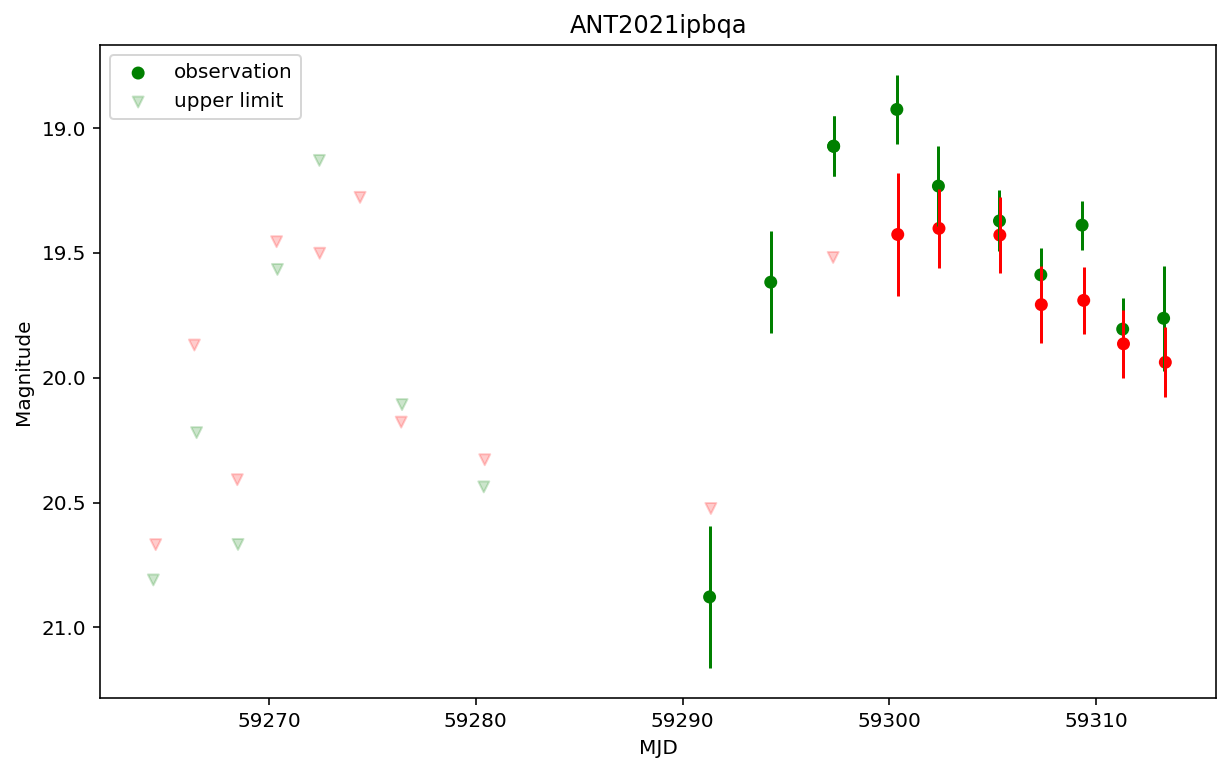

In [10]:
fig = plt.figure(figsize=(10,6))

x = df_candidates.ant_mjd
y = df_candidates.ant_mag
yerr = df_candidates.ant_magerr
c = df_candidates.ant_passband # green is g-band, red is R-band

plt.gca().invert_yaxis()
plt.scatter(x, y, c=c, marker='o', s=30, label='observation')
plt.errorbar(x, y, yerr=yerr, ecolor=c, fmt='', ls='')
plt.scatter(df_ulim.ant_mjd, df_ulim.ant_maglim, c=df_ulim.ant_passband, 
            marker='v', s=30, alpha=0.2, label='upper limit')
plt.xlabel('MJD')
plt.ylabel('Magnitude')
plt.legend(loc='upper left')
plt.title("ANT2021ipbqa")
plt.show()

In ~10 days, this locus rose ~ 2 mags in g-band, and is currently flattening out as of April 6, 2021.

According to the TNS page of this object: https://www.wis-tns.org/object/2021gyr, this object is a Supernova candidate as reported by the ALeRCE team. 
<img src="AT2021gyr.png">

> Note: the TNS link can be found using the TNS External Services Link attached to this locus' webpage on the ANTARES API.

 

Because this object is interesting, we should request a TOM toolkit observation to collect more data.
To do so, we should connect to TOM with our object as shown here: 
https://github.com/lchjoel1031/ANTARES/blob/main/ANTARES-TOM-AEON.ipynb

#### Looking at a non-anomalous light curve for comparison

Here is the light curve of the loci 'ANT2020pyjuu', found to have an anomaly score at the low-end: anom_score = 0.40125.

In [11]:
# get locus by ANTARES ID
locus_inlier = get_by_id("ANT2020pyjuu")
locus_inlier.tags

['lc_feature_extractor']

In [12]:
df_lc_inlier = pd.DataFrame(locus_inlier.lightcurve)
# Origin or type of the Alert. 1 = ZTF Candidate, 2 = ZTF Upper Limit.
df_candidates_inlier = df_lc_inlier[df_lc_inlier['ant_survey'] == 1]
df_ulim_inlier = df_lc_inlier[df_lc_inlier['ant_survey'] == 2]

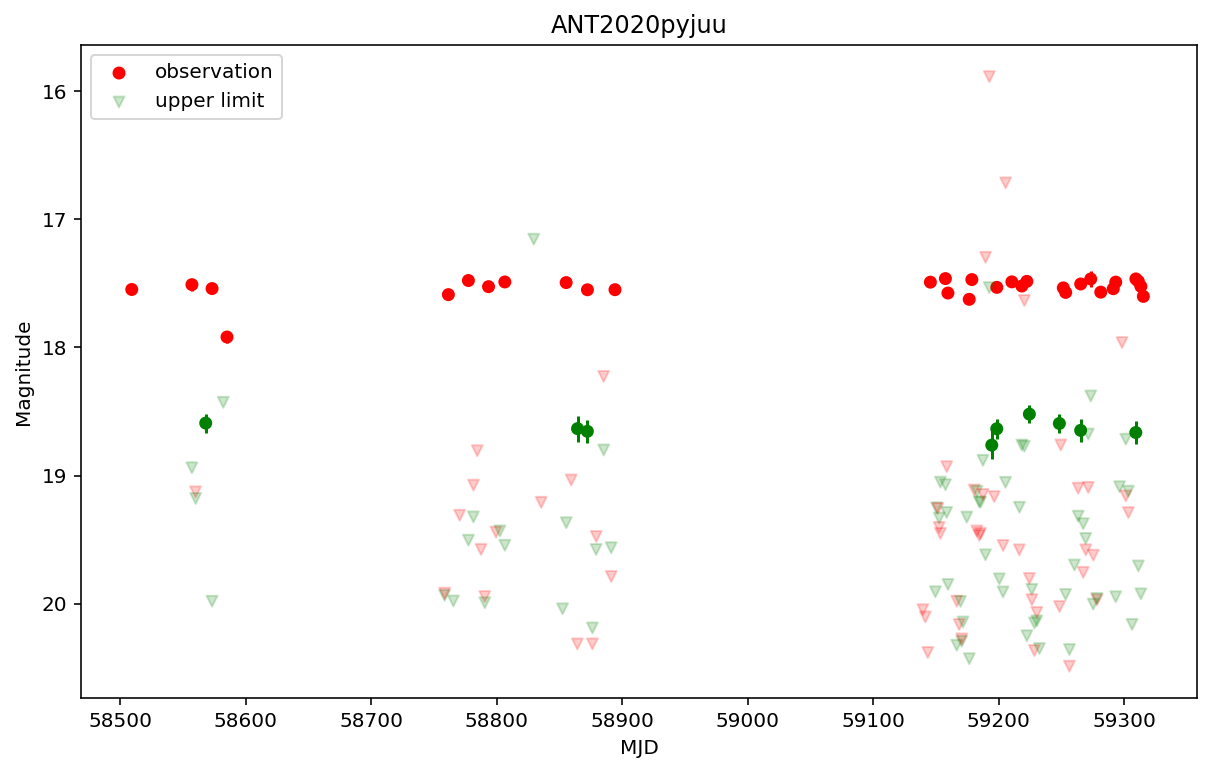

In [13]:
fig = plt.figure(figsize=(10,6))

x = df_candidates_inlier.ant_mjd
y = df_candidates_inlier.ant_mag_corrected
yerr = df_candidates_inlier.ant_magerr_corrected
c = df_candidates_inlier.ant_passband # green is g-band, red is R-band

plt.gca().invert_yaxis()
plt.scatter(x, y, c=c, marker='o', s=30, label='observation')
plt.errorbar(x, y, yerr=yerr, ecolor=c, fmt='', ls='')
plt.scatter(df_ulim_inlier.ant_mjd, df_ulim_inlier.ant_maglim, c=df_ulim_inlier.ant_passband, 
            marker='v', s=30, alpha=0.2, label='upper limit')
plt.xlabel('MJD')
plt.ylabel('Magnitude')
plt.legend(loc='upper left')
plt.title('ANT2020pyjuu')
plt.show()

This low anomaly score makes sense now, as this loci is particularly non-variable. 